In [1]:
import os
import shutil
import pandas as pd
import pydicom
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# Path to the Excel file containing the MRI coordinates
targeted_bx_path = '/Users/arjunmoorthy/Desktop/Research_Capstone/targeted_biopsy_patients.xlsx'

# Directory containing the DICOM images
dicom_dir_path = '/Users/arjunmoorthy/Desktop/t2axialimages'

# Load the Excel file
targeted_df = pd.read_excel(targeted_bx_path)

In [ ]:
""" patient_id = 'Prostate-MRI-US-Biopsy-0003'  # Test Patient ID

# Path to the patient's DICOM directory
patient_dicom_dir = os.path.join(dicom_dir_path, patient_id)
print(f"Searching in: {patient_dicom_dir}")  

z_coords = []
output_dir_path = os.path.join(dicom_dir_path, 'targeted_bx_slices_bothz')
# Walk through all subdirectories in the patient's DICOM directory
for root, dirs, files in os.walk(patient_dicom_dir):
    for file in files:
        if file.endswith(".dcm"):
            file_path = os.path.join(root, file)
            print(f"Reading DICOM: {file_path}")  
            ds = pydicom.dcmread(file_path)

            # Extract the z-coordinate
            if 'ImagePositionPatient' in ds:
                dicom_z_coord = ds.ImagePositionPatient[2]
                z_coords.append(round(dicom_z_coord, 2)) 
                print(f"Found z-coordinate: {dicom_z_coord}")  

# Check if any z-coordinates were found and print them
if z_coords:
    print(f"Z-coordinates for patient {patient_id}: {z_coords}")
else:
    print("No z-coordinates found.")
 """

In [3]:
# Assuming dicom_dir_path and targeted_bx_path are defined
output_dir_path = os.path.join(dicom_dir_path, 'targeted_bx_slices_bothz_all')

# Ensure the output directory exists
os.makedirs(output_dir_path, exist_ok=True)

# Load the Excel file
df = pd.read_excel(targeted_bx_path)

# Dictionary of Dicom data
# closest_slices = {}  # Format: {z_coord: (file_path, [list of (x,y) coords], min_diff)}

def find_and_copy_closest_slices(patient_id, series_id, bx_points):
    patient_dicom_dir = os.path.join(dicom_dir_path, patient_id)
    closest_slices = {}  # Format: {z_coord: (file_path, [list of (x,y) coords], min_diff)}

    # Walk through all subdirectories of the patient's DICOM directory
    for root, dirs, files in os.walk(patient_dicom_dir):
        for file in files:
            if file.endswith(".dcm"):
                file_path = os.path.join(root, file)
                ds = pydicom.dcmread(file_path, force=True)
                seriesinstanceuid = ds.SeriesInstanceUID if hasattr(ds, 'SeriesInstanceUID') else None
                if seriesinstanceuid is None:
                    print(f'{file_path} does not have seriesinstance uid')
                    continue
                if seriesinstanceuid == series_id:
                    if 'ImagePositionPatient' in ds:
                        dicom_z_coord = ds.ImagePositionPatient[2]
                        for z_coord, xy_coords in bx_points.items():
                            diff = abs(dicom_z_coord - z_coord)

                            if z_coord not in closest_slices or diff < closest_slices[z_coord][2]:
                                closest_slices[z_coord] = (file_path, [xy_coords], diff)
                            elif diff == closest_slices[z_coord][2]:
                                closest_slices[z_coord][1].append(xy_coords)  # Add xy_coords if the diff is equal
    
    # Copy the closest slices to the output directory
    output_patient_dir = os.path.join(output_dir_path, patient_id)
    os.makedirs(output_patient_dir, exist_ok=True)
    
    for z_coord, (file_path, xy_coords_list, _) in closest_slices.items():
        shutil.copy(file_path, output_patient_dir)
        print(f"Copied: {file_path} to {output_patient_dir} for z={z_coord} with xy points {xy_coords_list}")
    
    return closest_slices

targeted_patient_xy_info = []

# Convert DataFrame rows into a suitable structure for processing
for index, row in df.iterrows():
    patient_id = str(row['Patient Number'])
    series_id = str(row['Series Instance UID (MRI)'])
    # if patient_id=='Prostate-MRI-US-Biopsy-0005': break
    bx_points = {
        row['Bx Tip Z (MRI Coord)']: (row['Bx Tip X (MRI Coord)'], row['Bx Tip Y (MRI Coord)']),
        row['Bx Base Z (MRI Coord)']: (row['Bx Base X (MRI Coord)'], row['Bx Base Y (MRI Coord)'])
    }
    data = find_and_copy_closest_slices(patient_id, series_id, bx_points)

    targeted_patient_xy_info.append(data)




Copied: /Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-23.dcm to /Users/arjunmoorthy/Desktop/t2axialimages/targeted_bx_slices_bothz_all/Prostate-MRI-US-Biopsy-0001 for z=-41.906 with xy points [(-28.54, 15.165)]
Copied: /Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-15.dcm to /Users/arjunmoorthy/Desktop/t2axialimages/targeted_bx_slices_bothz_all/Prostate-MRI-US-Biopsy-0001 for z=-53.173 with xy points [(-35.082, 34.427)]
Copied: /Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-24.dcm to /Users/arjunmoorthy/Desktop/t2axialimages/targeted_bx_slices_bothz_all/Prostate-MRI-US-Biopsy-0001 for z=-40.452 with xy points [(-32.174, 24.978)]
Copied: /Users/arjun

In [13]:
# Folder for segmentations
seg_folder = '/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/Prostate-MRI-US-Biopsy'

In [14]:
targeted_patient_xy_info[4]

{-46.631: ('/Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-20.dcm',
  [(-28.177, 14.075)],
  0.24992598867400062),
 -57.17: ('/Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-13.dcm',
  [(-35.809, 34.791)],
  0.2889259886740021)}

In [6]:
data[0]

KeyError: 0

In [15]:
""" data_new =  {}
for z_coord,data in targeted_patient_xy_info[0].items():
    # print(z_coord,data)
    img_path = data[0]
    patient_name = data[0].split('/')[5]
    print(patient_name)
    img = pydicom.dcmread(img_path)
    imagePositionPatient = img.ImagePositionPatient
    study_id = img.StudyInstanceUID
    PixelSpacing = img.PixelSpacing
    instance_number = int(img.InstanceNumber)
    lps_x,lps_y = data[1][0]
    voxel_cord_x = round((lps_x-imagePositionPatient[0])/PixelSpacing[0])
    voxel_cord_y = round((lps_y-imagePositionPatient[1])/PixelSpacing[1])
    voxel_cord = [voxel_cord_x,voxel_cord_y,instance_number]
    
    tag_data = f'{patient_name}_{instance_number}'
    
    dicom_seg_path = f'{seg_folder}/{patient_name}/{study_id}'
    lesion_path = list(filter(lambda x:('lesion' in x) & ('surface' not in x),os.listdir(dicom_seg_path)))[0]
    lesion_image_path = f'{dicom_seg_path}/{lesion_path}'
    prostate_path = list(filter(lambda x:(x.endswith('prostate.dcm')) & ('surface' not in x),os.listdir(dicom_seg_path)))[0]               
    prostate_image_path = f'{dicom_seg_path}/{prostate_path}'
    
    prostate = pydicom.dcmread(prostate_image_path)
    prostate_arr = prostate.pixel_array
    prostate_arr = np.transpose(prostate_arr,(1,2,0)) #transpose to bring the axial axis to last position

    lesion = pydicom.dcmread(lesion_image_path)
    lesion_arr = lesion.pixel_array
    lesion_arr = np.transpose(lesion_arr,(1,2,0)) #transpose to bring the axial axis to last position
    
    seg = prostate_arr[:,:,instance_number-1]
    les = lesion_arr[:,:,instance_number-1]
    
    arr = img.pixel_array
    arr = np.stack((arr,) * 3, axis=-1)
    contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file
    contours2, _ = cv2.findContours(les, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file

    arr = cv2.drawContours(arr, contours, -1, (0, 255, 0), 2) #overlay the contour on the image
    arr = cv2.drawContours(arr, contours2, -1, (0, 0, 255), 2) #overlay the contour on the image

    add_data = {'path':img_path,'voxel_coords':voxel_cord,'instance_number':instance_number,'arr_img':arr}
    
    if tag_data not in data_new:
        data_new[tag_data] = [add_data]
    else:
        data_new[tag_data].append(add_data)
         """

Prostate-MRI-US-Biopsy-0001
Prostate-MRI-US-Biopsy-0001


In [15]:
data_new = {}
for i in range(len(targeted_patient_xy_info)):
    targeted_info = targeted_patient_xy_info[i]
    for z_coord,data in targeted_info.items():
        img_path = data[0]
        patient_name = data[0].split('/')[5]
        if (patient_name=='Prostate-MRI-US-Biopsy-0166') | (patient_name=='Prostate-MRI-US-Biopsy-1003')| (patient_name=='Prostate-MRI-US-Biopsy-1113'):
            continue
        dir_path = '/'.join(img_path.split('/')[:-1])
        all_slices = len(os.listdir(dir_path))  
        img = pydicom.dcmread(img_path)
        imagePositionPatient = img.ImagePositionPatient
        study_id = img.StudyInstanceUID
        PixelSpacing = img.PixelSpacing
        instance_number = int(img.InstanceNumber)
        lps_x,lps_y = data[1][0]
        voxel_cord_x = round((lps_x-imagePositionPatient[0])/PixelSpacing[0])
        voxel_cord_y = round((lps_y-imagePositionPatient[1])/PixelSpacing[1])
        voxel_cord = [voxel_cord_x,voxel_cord_y,instance_number]

        tag_data = f'{patient_name}_{instance_number}'

        dicom_seg_path = f'{seg_folder}/{patient_name}/{study_id}'
        lesion_path = list(filter(lambda x:('lesion' in x) & ('surface' not in x),os.listdir(dicom_seg_path)))
        if len(lesion_path)==0:
            lesion_path = ''
            lesion_image_path=''
        else:
            lesion_path = lesion_path[0]
            lesion_image_path = f'{dicom_seg_path}/{lesion_path}'
        prostate_path = list(filter(lambda x:(x.endswith('prostate.dcm')) & ('surface' not in x),os.listdir(dicom_seg_path)))
        if len(prostate_path)==0:
            prostate_path = ''
            prostate_image_path=''
        else:
            prostate_path = prostate_path[0]
            prostate_image_path = f'{dicom_seg_path}/{prostate_path}'
        
        # lesion_image_path = f'{dicom_seg_path}/{lesion_path}'
        # prostate_path = list(filter(lambda x:(x.endswith('prostate.dcm')) & ('surface' not in x),os.listdir(dicom_seg_path)))[0]
        # prostate_image_path = f'{dicom_seg_path}/{prostate_path}'

        if os.path.exists(prostate_image_path):
            prostate = pydicom.dcmread(prostate_image_path)
            prostate_arr = prostate.pixel_array
            prostate_arr = np.transpose(prostate_arr,(1,2,0)) #transpose to bring the axial axis to last position
        else:
            prostate_arr = np.zeros((int(img.Rows),int(img.Columns),all_slices))

        if os.path.exists(lesion_image_path):
            lesion = pydicom.dcmread(lesion_image_path)
            lesion_arr = lesion.pixel_array
            lesion_arr = np.transpose(lesion_arr,(1,2,0)) #transpose to bring the axial axis to last position
        else:
            lesion_arr = np.zeros((int(img.Rows),int(img.Columns),all_slices))
            
        seg = prostate_arr[:,:,instance_number-1]
        les = lesion_arr[:,:,instance_number-1]

        arr = img.pixel_array
        arr = np.stack((arr,) * 3, axis=-1)
        if os.path.exists(prostate_image_path):
            contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file
        if os.path.exists(lesion_image_path):
            contours2, _ = cv2.findContours(les, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file

        if os.path.exists(prostate_image_path):
            arr = cv2.drawContours(arr, contours, -1, (0, 255, 0), 2) #overlay the contour on the image
        if os.path.exists(lesion_image_path):
            arr = cv2.drawContours(arr, contours2, -1, (0, 0, 255), 2) #overlay the contour on the image

        add_data = {'path':img_path,'voxel_coords':voxel_cord,'instance_number':instance_number,'arr_img':arr}
        
        if tag_data not in data_new:
            data_new[tag_data] = [add_data]
        else:
            data_new[tag_data].append(add_data)


In [10]:
os.listdir(dicom_seg_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001/1.3.6.1.4.1.14519.5.2.1.85548304921965658367726869399297351743'

In [16]:
os.path.exists('/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data')

False

In [36]:
lesion_path = list(filter(lambda x:('lesion' in x) & ('surface' not in x),os.listdir(dicom_seg_path)))
if len(lesion_path)==0:
    lesion_path = ''
else:
    lesion_path = lesion_path[0]
lesion_image_path = f'{dicom_seg_path}/{lesion_path}'
lesion_image_path

'/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0166/1.3.6.1.4.1.14519.5.2.1.176557933984921276307047324188207737181/'

In [54]:
prostate_arr.shape,instance_number
print(patient_name,prostate_image_path,lesion_image_path)

Prostate-MRI-US-Biopsy-1113 /Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-1113/1.3.6.1.4.1.14519.5.2.1.209375449388093865298073010652851133033/300-SEG-Segmentation of prostate.dcm /Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-1113/1.3.6.1.4.1.14519.5.2.1.209375449388093865298073010652851133033/300-SEG-Segmentation of prostate lesion 1.dcm


In [56]:
print(all_slices)

60


In [57]:
prostate_arr.shape,lesion_arr.shape

((256, 256, 60), (256, 256, 60))

In [48]:
print(os.listdir(dicom_seg_path))

['300-SEG-Segmentation of prostate lesion 2.dcm', '1-M3D-STL surface of prostate.dcm', '1-M3D-STL surface of lesion 2.dcm', '300-SEG-Segmentation of prostate.dcm']


In [24]:
# print(os.listdir(dicom_seg_path))
dir_path = '/'.join(img_path.split('/')[:-1])
all_slices = len(os.listdir(dir_path))
print(all_slices)

33


In [25]:
if os.path.exists(prostate_image_path):
prostate = pydicom.dcmread(prostate_image_path)
prostate_arr = prostate.pixel_array
prostate_arr = np.transpose(prostate_arr,(1,2,0)) #transpose to bring the axial axis to last position
else:
prostate_arr = np.zeros((int(img.Rows),int(img.Columns),all_slices))

if os.path.exists(lesion_image_path):
lesion = pydicom.dcmread(lesion_image_path)
lesion_arr = lesion.pixel_array
lesion_arr = np.transpose(lesion_arr,(1,2,0)) #transpose to bring the axial axis to last position
else:
lesion_arr = np.zeros((int(img.Rows),int(img.Columns),all_slices))

seg = prostate_arr[:,:,instance_number-1]
les = lesion_arr[:,:,instance_number-1]

arr = img.pixel_array
arr = np.stack((arr,) * 3, axis=-1)
if os.path.exists(prostate_image_path):
contours, = cv2.findContours(seg, cv2.RETREXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file
if os.path.exists(lesion_image_path):
contours2, = cv2.findContours(les, cv2.RETREXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #function to extract the contours from the given mask file

if os.path.exists(prostate_image_path):
arr = cv2.drawContours(arr, contours, -1, (0, 255, 0), 2) #overlay the contour on the image
if os.path.exists(lesion_image_path):
arr = cv2.drawContours(arr, contours2, -1, (0, 0, 255), 2) #overlay the contour on the image

/Users/arjunmoorthy/Desktop/t2axialimages/Prostate-MRI-US-Biopsy-0166/05-14-2010-NA-MR PELVIS OUTSIDE IMAGING-37181/11.000000-AX FSE T2 SMALL-58346


In [ ]:
data_new.keys()

In [40]:
thickness = 1
font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 0.3
# Blue color in BGR 
color2 = (255, 128, 0)
op_dir = '/Users/arjunmoorthy/Desktop/annotated_imgs'
for idx,(key,value) in enumerate(data_new.items()):
    print(key)
    patient_name = key.rsplit('_')[0]
    op_folder = os.path.join(op_dir,patient_name)
    os.makedirs(op_folder, exist_ok=True)
    arr_img = value[0]['arr_img']
    
    for i in range(len(value)):
        
        voxel_cord = value[i]['voxel_coords']
        voxel_cord_x = voxel_cord[0]
        voxel_cord_y = voxel_cord[1]
        #extract the coords of x and y and plot it on the processed image as a circle point
        arr_img = cv2.circle(arr_img, (voxel_cord_x,voxel_cord_y), radius=1, color=color2, thickness=-1)
       # arr_img = cv2.putText(arr_img, text, (voxel_cord_x,voxel_cord_y-5), font,fontScale, color2, thickness, cv2.LINE_AA)
        
    cv2.imwrite(f'{op_folder}/{key}.jpg',cv2.cvtColor(arr_img.astype('uint16'),cv2.COLOR_BGR2RGB))
    #break

Prostate-MRI-US-Biopsy-0001_23
Prostate-MRI-US-Biopsy-0001_15
Prostate-MRI-US-Biopsy-0001_24
Prostate-MRI-US-Biopsy-0001_16
Prostate-MRI-US-Biopsy-0001_20
Prostate-MRI-US-Biopsy-0001_13
Prostate-MRI-US-Biopsy-0001_14
Prostate-MRI-US-Biopsy-0001_35
Prostate-MRI-US-Biopsy-0001_27
Prostate-MRI-US-Biopsy-0001_31
Prostate-MRI-US-Biopsy-0001_22
Prostate-MRI-US-Biopsy-0002_36
Prostate-MRI-US-Biopsy-0002_30
Prostate-MRI-US-Biopsy-0002_35
Prostate-MRI-US-Biopsy-0002_29
Prostate-MRI-US-Biopsy-0002_37
Prostate-MRI-US-Biopsy-0002_31
Prostate-MRI-US-Biopsy-0002_43
Prostate-MRI-US-Biopsy-0002_21
Prostate-MRI-US-Biopsy-0002_26
Prostate-MRI-US-Biopsy-0002_34
Prostate-MRI-US-Biopsy-0002_27
Prostate-MRI-US-Biopsy-0002_25
Prostate-MRI-US-Biopsy-0003_41
Prostate-MRI-US-Biopsy-0003_32
Prostate-MRI-US-Biopsy-0003_43
Prostate-MRI-US-Biopsy-0003_33
Prostate-MRI-US-Biopsy-0003_40
Prostate-MRI-US-Biopsy-0003_31
Prostate-MRI-US-Biopsy-0005_38
Prostate-MRI-US-Biopsy-0005_30
Prostate-MRI-US-Biopsy-0005_36
Prostate

In [19]:
data_new.keys()

dict_keys(['Prostate-MRI-US-Biopsy-0001_23', 'Prostate-MRI-US-Biopsy-0001_15', 'Prostate-MRI-US-Biopsy-0001_24', 'Prostate-MRI-US-Biopsy-0001_16', 'Prostate-MRI-US-Biopsy-0001_20', 'Prostate-MRI-US-Biopsy-0001_13', 'Prostate-MRI-US-Biopsy-0001_14', 'Prostate-MRI-US-Biopsy-0001_35', 'Prostate-MRI-US-Biopsy-0001_27', 'Prostate-MRI-US-Biopsy-0001_31', 'Prostate-MRI-US-Biopsy-0001_22', 'Prostate-MRI-US-Biopsy-0002_36', 'Prostate-MRI-US-Biopsy-0002_30', 'Prostate-MRI-US-Biopsy-0002_35', 'Prostate-MRI-US-Biopsy-0002_29', 'Prostate-MRI-US-Biopsy-0002_37', 'Prostate-MRI-US-Biopsy-0002_31', 'Prostate-MRI-US-Biopsy-0002_43', 'Prostate-MRI-US-Biopsy-0002_21', 'Prostate-MRI-US-Biopsy-0002_26', 'Prostate-MRI-US-Biopsy-0002_34', 'Prostate-MRI-US-Biopsy-0002_27', 'Prostate-MRI-US-Biopsy-0002_25', 'Prostate-MRI-US-Biopsy-0003_41', 'Prostate-MRI-US-Biopsy-0003_32', 'Prostate-MRI-US-Biopsy-0003_43', 'Prostate-MRI-US-Biopsy-0003_33', 'Prostate-MRI-US-Biopsy-0003_40', 'Prostate-MRI-US-Biopsy-0003_31', 'Pr

In [20]:
key

'Prostate-MRI-US-Biopsy-0030_9'

In [35]:
arr_img.shape,arr_img.dtype

((256, 256, 3), dtype('uint16'))

In [37]:
arr_img.astype('uint16')

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [29, 29, 29],
        [25, 25, 25],
        [ 7,  7,  7]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint16)

In [29]:
import matplotlib.pyplot as plt

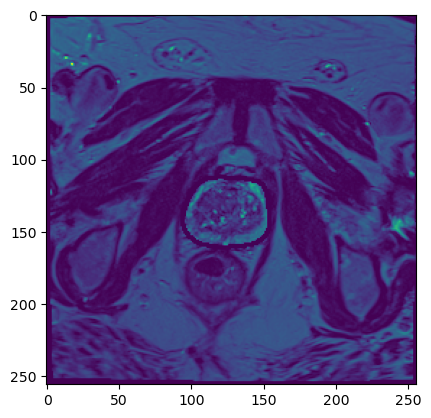

In [31]:
plt.imshow(arr_img[...,0])